# Temporal And Spatial Analysis of Downtown Homeless Sleepers

This notebook is an example of temporal and spatial analysis of homeless sleepers in downtown San Diego. 


In [1]:
from IPython.display import clear_output
try:
    import metapack
except ModuleNotFoundError:
    !pip install -q -U git+https://github.com/Metatab/metapack#egg=metapack
try:
    import mapclassify
except ModuleNotFoundError:
    !pip install -q -U mapclassify


clear_output()

In [2]:
import seaborn as sns

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import mapclassify
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')



In [3]:
import metapack as mp
mp.jupyter.init()

In [4]:
#pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg = mp.open_package('http://library.metatab.org/sandiegodata.org-dowtown_homeless-9.zip')

pkg

# Downtown San Diego Homeless Sleepers
`sandiegodata.org-dowtown_homeless-9` Last Update: 2019-10-03T18:22:47

_Five years of monthly geographic positions for homeless sleepers in Downtown San Diego_


This dataset provides geographic locations for homeless sleepers in Downtown San Diego, as counted by enumerators from the Downtown San Diego Partnership. These counts have been done monthly since 2012, and this dataset provides counts since 2014. 

<center><a
href="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless
-Sleepers.png"><img
src="https://data.sandiegodata.org/wp-content/uploads/sites/18/2019/10/Homeless-
Sleepers.png" width="400px"></a></center>


The count is done on paper maps with handwritten count marks. The San Diego
Regional Data Library's [Downton Homelessness
project](http://downtown-homelessness.sandiegodata.org/) converted these
scanned count maps using a [web based image annotation
tool](http://www.robots.ox.ac.uk/~vgg/software/via/).

## Base and Imputed Datasets

This distribution has two version of the homeless counts, the base set,
``homeless_counts``, which has three months of missing data, and the imputed
dataset, ``imputed_counts`` in which these three missing months, 2014-08,
2014-09, and 2015-06 are probabilistically re-created.

The Imputation process uses the total count for the month, from the
``monthly_totals`` dataset, as the number of sleepers that the imputed month
will have. Then, the imputation process collects at least 1,000 records with
dates near the missing month into a sample set, calculating the portion of
records that are in each census block. Then the algorithm randomly selects that
number of records for each census block, and adjusts random blocks so the total
of the whole set of selected records is equal to the official count for the
month.

The result is an imputed month that has the same number of records as the
official count for the month and as the same portion of sleepers in each census
block as in adjacent months.

## Notes

Notes for the source dataset, as of April 2019:

The preliminary methodology (shown in yellow) [ March 2017 and earlier] counted
two individuals per tent and two individuals per vehicle.

On April 27, 2017, the Clean & Safe program adopted the counting methodology
used by the Regional Task Force on the Homeless. Per the methodology
(represented above by the dark green cells), [April 2017 to April 2018,
inclusive ] Clean & Safe staff counted 1.75 individuals per visible
tent/structure and 1.66 individuals per vehicle that showed clear signs of
habitation.

In May 2018, the Regional Task Force on the Homeless updated the methodology
for vehicles to 2.03 that shows clear signs of habitation (the methodology of
1.75 individuals per tent/structure remained the same). The Clean & Safe
program implemented this methodology on May 31, 2018 (represented in orange).

\* Denotes the months that The Downtown Fellowship of Ministries and Churches collaborated with us on the monthly homeless sleep count.

\*\*East Village breakout areas include the following:
    * North East East Village is the area north of Market Street & east of Park Ave. 
    * North West is the area north of Market Street & west of Park Ave.
    * South East is the area east of Park Ave. south of Market Street
    * South West is the area west of Park Ave. south of Market Street

## Caveats

Because this data is extracted, manually, from manually recorded maps, there
are a lot of quality issues. 

### Missing Months

Because of conversion errors and some complications with the source maps, there
are several months of data that are excluded from this dataset

* **August 2014**. In the original datasets, August 2014 was a duplicate of September 2014. 
* **September 2014**. Comfusion related to the duplication of September and August resulted in September being incompletely processed. 
* **June 2015**. All of the map images for this month were blank. An alternate source PDF

In [5]:
mt = pkg.resource('monthly_totals').dataframe()
hc = pkg.resource('homeless_counts').dataframe()
hc['records'] = 1

ic = pkg.resource('imputed_counts').geoframe()
ic['records'] = 1

# Time Series

There are two datasets in the data package. The first has three missing months, which you can see as dips in the time series. The second has these missing months imputed. Also note that the official statistics, the blue line, cover a longer time period that the counts from this dataset. However, the official stats do not include geographic positions. 

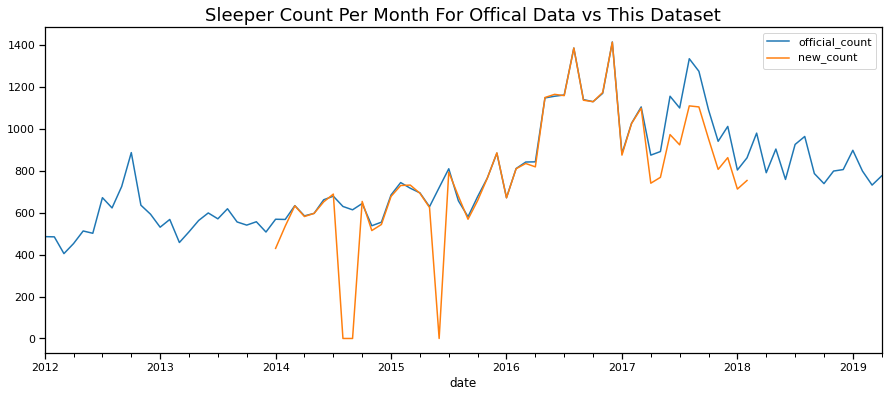

In [6]:
t = hc.set_index('date').groupby(pd.Grouper(freq="MS")).records.count().to_frame().rename(columns={'records':'new_count'})
mt = mt.set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.plot(figsize=(15,6))
ax.set_title('Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);

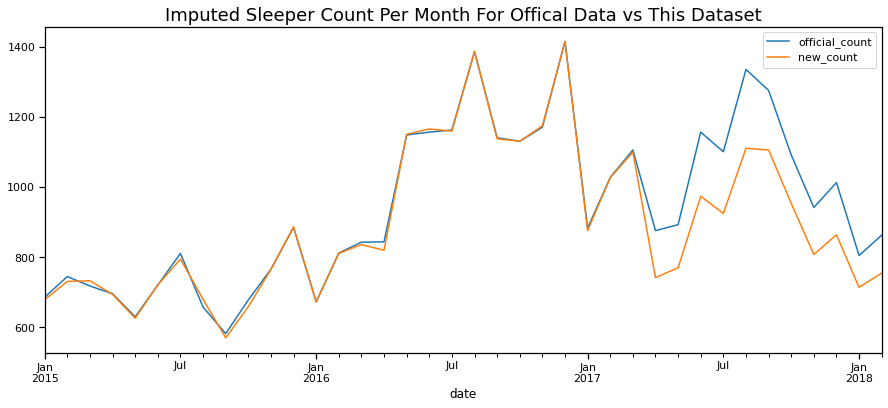

In [7]:

t = ic.set_index('date').groupby(pd.Grouper(freq="MS")).records.count().to_frame().rename(columns={'records':'new_count'})
mt = pkg.resource('monthly_totals').dataframe().set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'count':'official_count'})

j = mt.join(t)
ax = j.loc['2015':'2018-02-01'].plot(figsize=(15,6))
ax.set_title('Imputed Sleeper Count Per Month For Offical Data vs This Dataset', fontsize=18);


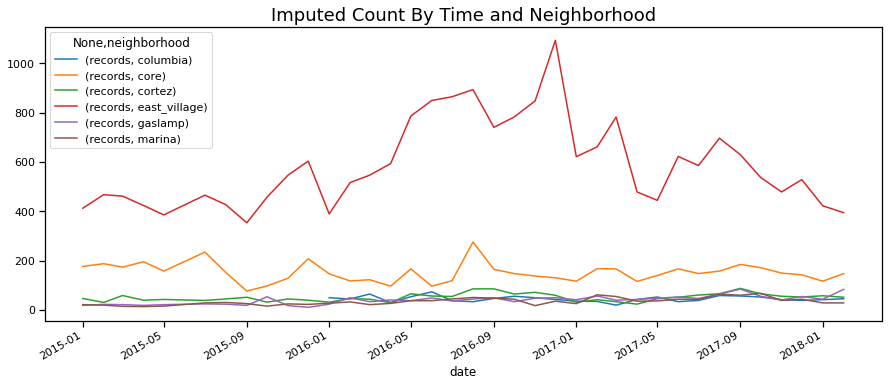

In [8]:

t = hc.set_index('date').groupby([pd.Grouper(freq="MS"), 'neighborhood']).records.count().to_frame()
ax=t.unstack().loc['2015':'2018-02-01'].plot(figsize=(15,6));
ax.set_title('Imputed Count By Time and Neighborhood', fontsize=18);

# Geographic Analysis

In this geographic analysis, we'll load in a variety of other datasets and compare the spatial distribution to that of the homeless sleepers, and do a simple correlation at the block level. 

The datasets we will load are: 
* Homeless sleeper counts
* Business locations
* Crimes,  for drugs, alcohol, assault and vandalism
* Pedestrian density, at different times of the day


In [9]:
# Blocks
blocks = pkg.resource('downtown_blocks').geoframe().rename(columns={'geoid10':'geoid'})
blocks = blocks[['geoid', 'geometry']]

In [10]:
# Homeless Counts

# The Homeless sleepers file already has block geoids, so we can do a non-spatial merge
# just to get the block geometry
t =  blocks.merge(ic[['geoid', 'records']], on='geoid').rename(columns={'records':'sleepers'})

# Since sleepers is a dummy variable, aggregation with sum is the same as count
hc_blocks = t.groupby('geoid').count().sleepers.to_frame()


In [11]:
# Businesses
businesses = mp.open_package('metatab+http://library.metatab.org/sangis.org-business_sites.csv').resource('business_sites').geoframe()
bus_blocks = gpd.sjoin(blocks, businesses).groupby('geoid').count().id.to_frame().rename(columns={'id':'businesses'})


In [12]:
# Crime

pkg = mp.open_package('http://library.metatab.org/sandag.gov-crime-2007e2013-2.1.4.csv')

# Create Dataframes
crime = pkg.resource('incidents').geoframe()

In [13]:
crime.columns

Index(['datetime', 'year', 'month', 'day', 'week', 'dow', 'time', 'hour',
       'is_night', 'category', 'address', 'city', 'segment_id', 'nbrhood',
       'community', 'comm_pop', 'council', 'council_pop', 'geoid', 'asr_zone',
       'lampdist', 'lat', 'lon', 'desc', 'gctype', 'gcquality', 'geometry'],
      dtype='object')

In [14]:
# Crime types:
# ['THEFT/LARCENY', 'FRAUD', 'SEX CRIMES', 'VANDALISM', 'VEHICLE BREAK-IN/THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT',
#  'ROBBERY', 'DUI', 'ASSAULT', 'DRUGS/ALCOHOL VIOLATIONS', 'ARSON','WEAPONS', 'HOMICIDE']

t = crime[crime['desc'].isin(['ASSAULT','VANDALISM', 'DRUGS/ALCOHOL VIOLATIONS'])]
t = gpd.sjoin(blocks, t).rename(columns={'geoid_left':'geoid'})
t['crimes'] = 1
crime_blocks = t.groupby('geoid').count().crimes.to_frame()

In [15]:
# Pedestrians
ped = mp.open_package('http://library.metatab.org/sandiegodata.org-pedestrian-blocks-1.zip').resource('ped_blocks').dataframe()

# 6 is Saturday
# 3 is Monday
ped1 = ped[(ped.dow==6) & (ped.tod=='evening')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'sat_eve_ped'}).reset_index()
ped2 = ped[(ped.dow==3) & (ped.tod=='lunch')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'wed_lunch_ped'}).reset_index()
ped3 = ped[(ped.dow==3) & (ped.tod=='night')].set_index(['geoid','tod'])[['density']].rename(columns={'density':'wed_night_ped'}).reset_index()

#ped =ped[['geoid','rank']].rename(columns={'rank':'pedestrians'})
ped = ped1[['geoid','sat_eve_ped']]\
      .merge(ped2[['geoid','wed_lunch_ped']], on='geoid')\
      .merge(ped3[['geoid','wed_night_ped']], on='geoid')
        
df = blocks.merge(crime_blocks, on='geoid', how='left')\
           .merge(hc_blocks, on='geoid', how='left')\
           .merge(bus_blocks, on='geoid', how='left')\
           .merge(ped,on='geoid', how='left')
           
for c in df.columns:
  if c != 'geometry':
    df[c] = df[c].fillna(0)

## Correlations

Coarse correlations between blocks. Homelessness sleapers correlates a little with drug and alcohol crime, but not much else. 


In [16]:
df[['crimes','sleepers','businesses', 'sat_eve_ped', 'wed_lunch_ped', 'wed_night_ped']].corr()

,crimes,sleepers,businesses,sat_eve_ped,wed_lunch_ped,wed_night_ped
crimes,1.000000,-0.009977,0.006234,0.022919,-0.032214,0.032965
sleepers,-0.009977,1.000000,-0.006827,0.032661,0.084139,0.044396
businesses,0.006234,-0.006827,1.000000,0.131604,0.022841,0.188799
sat_eve_ped,0.022919,0.032661,0.131604,1.000000,0.229896,0.825919
wed_lunch_ped,-0.032214,0.084139,0.022841,0.229896,1.000000,0.486369
wed_night_ped,0.032965,0.044396,0.188799,0.825919,0.486369,1.000000


## Maps of All Variables

This view of the data is just the visualization of the spatial distributions; it is not a sophisticated analysis. However, it does give you a visual sense of the correlations in the previous section. 

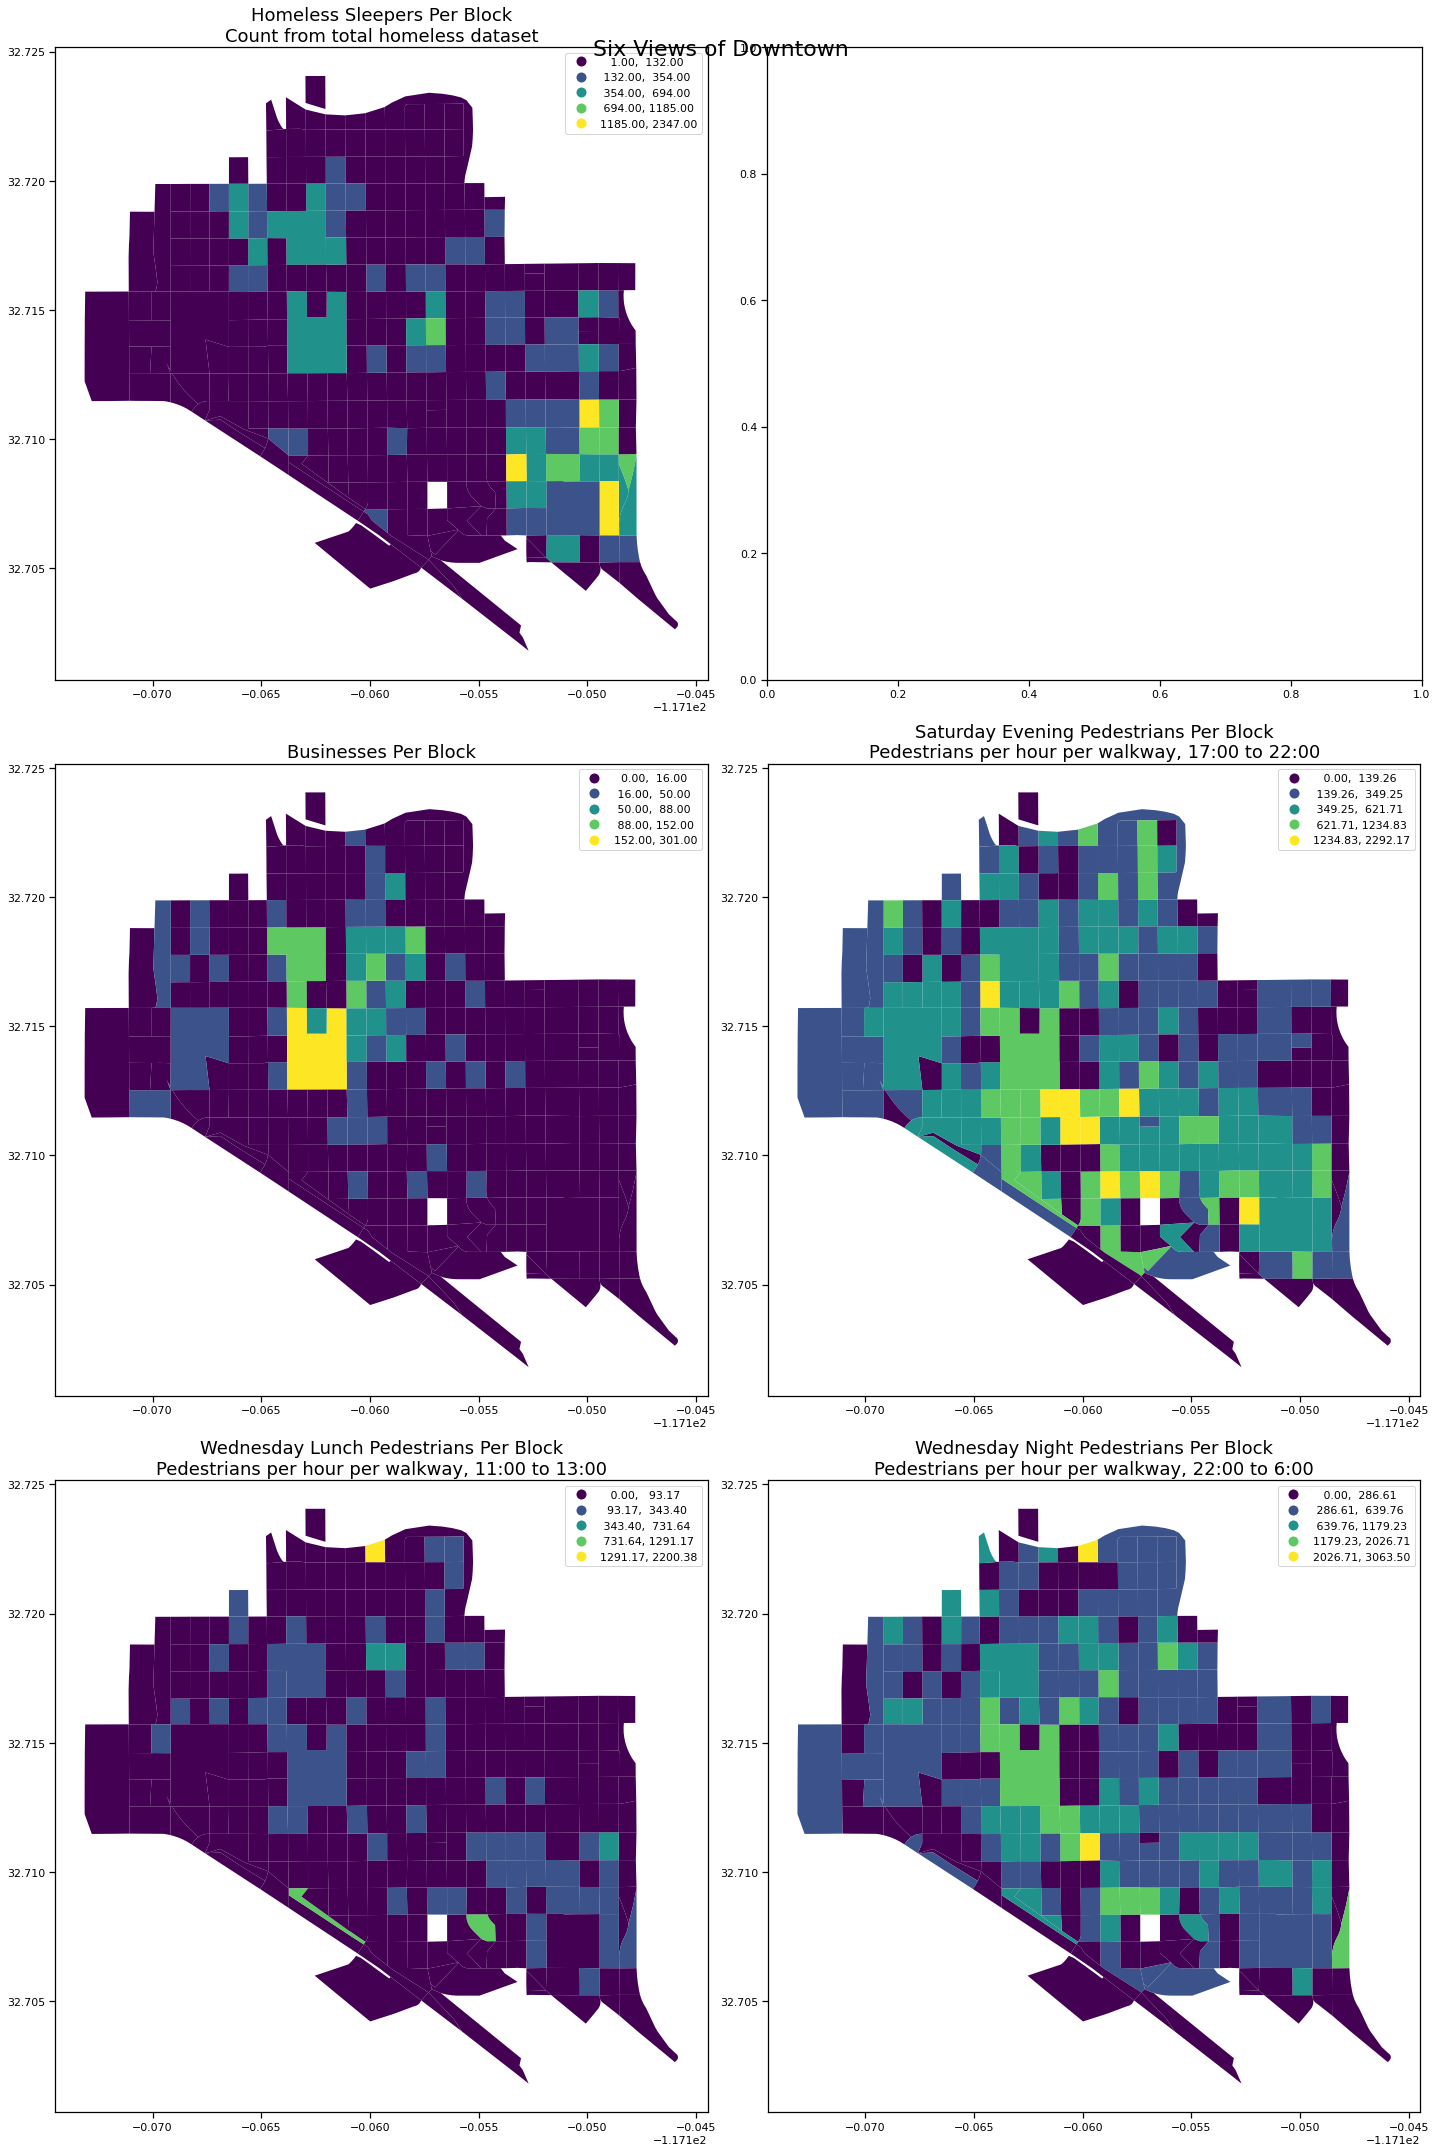

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20,30))
axes = axes.flat

df.plot(ax=axes[0], column='sleepers', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[0].set_title("Homeless Sleepers Per Block\nCount from total homeless dataset", fontsize=18);

#df.plot(ax=axes[1], column='crimes', figsize=(10,10), scheme='fisher_jenks', legend=True);
#axes[1].set_title("Crimes Per Block\nTotal Drug/Alcohol violations, 2007 to 2012", fontsize=18);

df.plot(ax=axes[2], column='businesses', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[2].set_title("Businesses Per Block", fontsize=18);

df.plot(ax=axes[3], column='sat_eve_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[3].set_title("Saturday Evening Pedestrians Per Block\nPedestrians per hour per walkway, 17:00 to 22:00", fontsize=18);

df.plot(ax=axes[4], column='wed_lunch_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[4].set_title("Wednesday Lunch Pedestrians Per Block\nPedestrians per hour per walkway, 11:00 to 13:00", fontsize=18);

df.plot(ax=axes[5], column='wed_night_ped', figsize=(10,10), scheme='fisher_jenks', legend=True);
axes[5].set_title("Wednesday Night Pedestrians Per Block\nPedestrians per hour per walkway, 22:00 to 6:00", fontsize=18);

fig.suptitle('Six Views of Downtown', fontsize=22)
plt.tight_layout()


# Homeless Shelter Tent

In November 2017, the City of San Diego [opened a homeless tent at 1402 Commercial](https://www.nbcsandiego.com/news/local/Temporary-Homeless-Shelters-to-go-up-in-Three-San-Diego-Locations-457376853.html), in the South West corner of East Village. Here we will look at the homeless counts within a 1/2 mile radius of the tent location, before and after the tent was installed.  


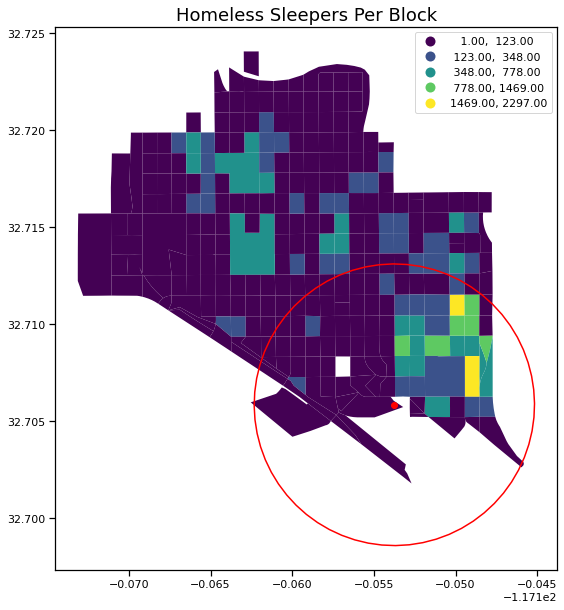

In [26]:

from shapely.geometry import Point

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry', crs=4326)

# Buffer point. Convert CRS to do the buffering in feet
pt_1000 =  gpd.GeoDataFrame({'geometry':pt.to_crs(2230).buffer(5280/2).to_crs(4326)}, crs=4326)

j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(10,10), scheme='fisher_jenks', legend=True);

ax.set_title("Homeless Sleepers Per Block", fontsize=18);

pt_1000.geometry.boundary.plot(ax=ax, color='red')
pt.plot(ax=ax, color='red')

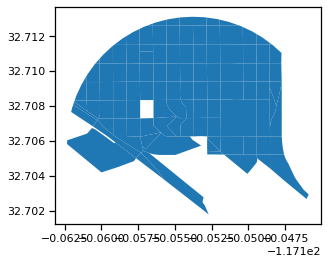

In [27]:
ints =  gpd.overlay(pt_1000, df, how='intersection')
ints.plot()

In [20]:
ints.head()

,geoid,crimes,sleepers,businesses,sat_eve_ped,wed_lunch_ped,wed_night_ped,geometry
0,10100US060730054004017,0.0,6,6.0,538.583333,62.750000,618.125000,"POLYGON ((-117.15739 32.71065, -117.15739 32.7..."
1,10100US060730054004023,0.0,10,6.0,1710.666667,119.750000,1262.062500,"POLYGON ((-117.15736 32.70835, -117.15738 32.7..."
2,10100US060730054001014,1.0,13,13.0,0.000000,0.000000,0.000000,"POLYGON ((-117.16082 32.70832, -117.16027 32.7..."
3,10100US060730054001009,0.0,21,0.0,144.833333,12.000000,97.166667,"POLYGON ((-117.16198 32.70790, -117.16191 32.7..."
4,10100US060730052001037,0.0,43,4.0,495.203704,85.888889,555.138889,"POLYGON ((-117.15210 32.71154, -117.15265 32.7..."


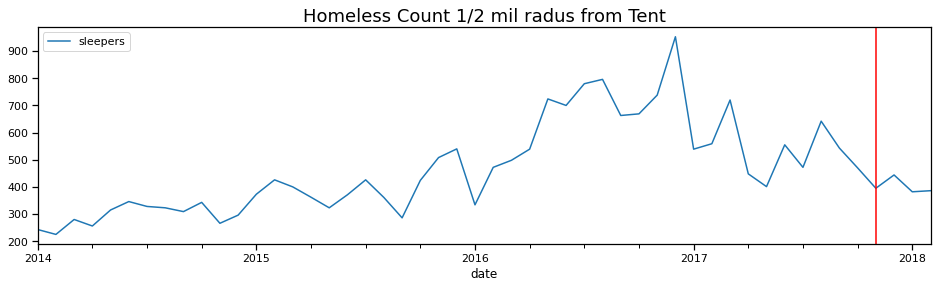

In [21]:
t = gpd.GeoDataFrame(ints[['geoid']].merge(ic, on='geoid'), geometry='geometry')
t = t[['records','date']].set_index('date').groupby(pd.Grouper(freq="MS")).sum().rename(columns={'records':'sleepers'})
ax = t.plot(figsize=(16, 4))
ax.axvline(x='2017-11-01', color='red');
ax.set_title('Homeless Count 1/2 mil radus from Tent', fontsize=18);

In [22]:
# Police and sheriff station locations
policeHQ = gpd.GeoDataFrame([[Point(-117.151180,32.715280)]], columns=['geometry'], geometry='geometry')
sheriffsDept = gpd.GeoDataFrame([[Point(-117.160820,32.720180)]], columns=['geometry'], geometry='geometry')

# Trolley stations
tAmericaPlaza = gpd.GeoDataFrame([[Point(-117.168896,32.717294)]], columns=['geometry'], geometry='geometry')
tCourthouse = gpd.GeoDataFrame([[Point(-117.165952,32.717225)]], columns=['geometry'], geometry='geometry')
tCivicCenter = gpd.GeoDataFrame([[Point(-117.162245,32.717156)]], columns=['geometry'], geometry='geometry')
t5thAve = gpd.GeoDataFrame([[Point(-117.159655,32.716908)]], columns=['geometry'], geometry='geometry')
tCityCollege = gpd.GeoDataFrame([[Point(-117.154045,32.716235)]], columns=['geometry'], geometry='geometry')
tParkMarket = gpd.GeoDataFrame([[Point(-117.153655,32.711746)]], columns=['geometry'], geometry='geometry')
t12thImperial = gpd.GeoDataFrame([[Point(-117.154099,32.705815)]], columns=['geometry'], geometry='geometry')
tGaslamp = gpd.GeoDataFrame([[Point(-117.159697,32.707435)]], columns=['geometry'], geometry='geometry')
tConvention = gpd.GeoDataFrame([[Point(-117.163695,32.709603)]], columns=['geometry'], geometry='geometry')
tSeaportVillage = gpd.GeoDataFrame([[Point(-117.168701,32.712519)]], columns=['geometry'], geometry='geometry')

# Shelters & services
# shNuevaVida = gpd.GeoDataFrame([[Point(-117.163430,32.724420)]], columns=['geometry'], geometry='geometry')
shCatholicCharities = gpd.GeoDataFrame([[Point(-117.161450,32.721760)]], columns=['geometry'], geometry='geometry')
shYWCAcortez = gpd.GeoDataFrame([[Point(-117.155330,32.717110)]], columns=['geometry'], geometry='geometry')
shRachelsNight = gpd.GeoDataFrame([[Point(-117.157120,32.713330)]], columns=['geometry'], geometry='geometry')
shSalvationArmy = gpd.GeoDataFrame([[Point(-117.148580,32.709230)]], columns=['geometry'], geometry='geometry')
shTravelersAid = gpd.GeoDataFrame([[Point(-117.149880,32.705790)]], columns=['geometry'], geometry='geometry')
# shStVincent = gpd.GeoDataFrame([[Point(-117.136010,32.706360)]], columns=['geometry'], geometry='geometry')
shPATHConnections = gpd.GeoDataFrame([[Point(-117.159461,32.719494)]], columns=['geometry'], geometry='geometry')
serTransitionalStorage = gpd.GeoDataFrame([[Point(-117.149730,32.708090)]], columns=['geometry'], geometry='geometry')
serNeilGoodDayCenter = gpd.GeoDataFrame([[Point(-117.148240,32.709216)]], columns=['geometry'], geometry='geometry')



In [28]:
from colorspacious import cspace_converter
from collections import OrderedDict

In [29]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [32]:
from mpltools import style
from mpltools import layout

In [33]:
import matplotlib.patches as mpatches

(-117.17449529999999, -117.14445869999999, 32.70069015, 32.72517285)

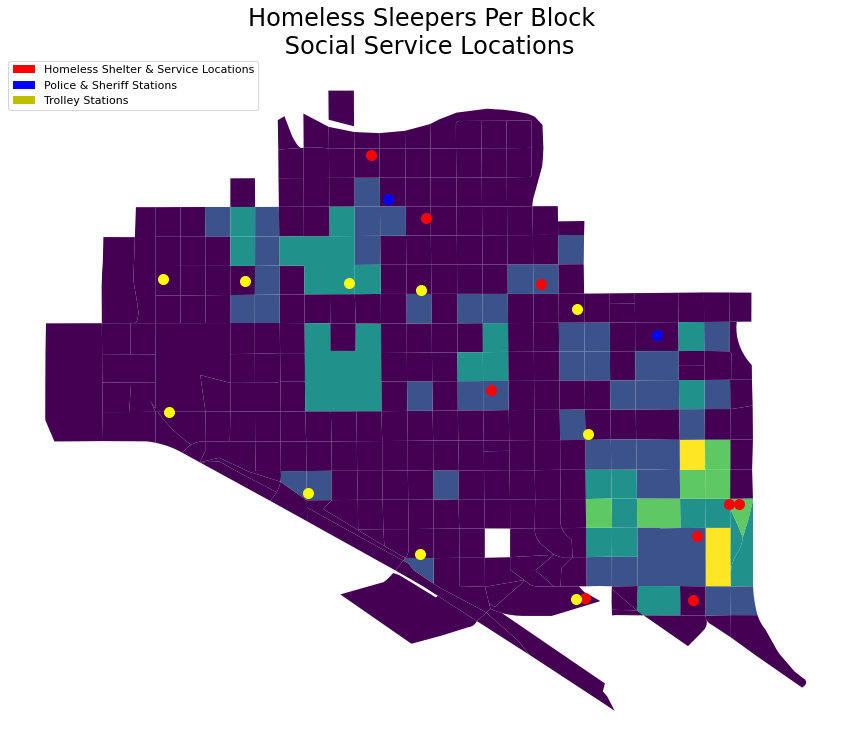

In [34]:
from shapely.geometry import Point

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry')
# policeHQ = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry', crs={'init': 'epsg:4326'})


# Buffer point. Convert CRS to do the buffering in feet
# pt_1000 =  gpd.GeoDataFrame({'geometry':pt.to_crs({'init':'epsg:2230'}).buffer(5280/2).to_crs({'init':'epsg:4326'})}, crs={'init': 'epsg:4326'})

j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(15,15), scheme='fisher_jenks', legend=True);
# ax = j.plot(column='records', figsize=(15,15), scheme='fisher_jenks');
# ax = j.plot(column='records', figsize=(15,15), legend=True);
# plt.style.use('seaborn-muted')

labels1=["Homeless Shelter & Service Locations", "Police & Sheriff Stations", "Trolley Stations"]
red_patch = mpatches.Patch(facecolor='r') #this will create a red bar with black borders, you can leave out edgecolor if you do not want the borders
blue_patch = mpatches.Patch(facecolor='b')
yellow_patch = mpatches.Patch(facecolor='y')

plt.legend(handles = [red_patch, blue_patch, yellow_patch],labels=labels1,
       loc="upper left", 
       borderaxespad=0.1)

# labels2=["1 - 123 homeless sleepers", "124-348 homeless sleepers", "349-778 homeless sleepers", "779-1469 homeless sleepers", "1470+ homeless sleepers"]
# lowest_group = mpatches.Patch(facecolor="purple")
# low_group = mpatches.Patch(facecolor="navy")
# med_group = mpatches.Patch(facecolor="aqua")
# higher_group = mpatches.Patch(facecolor="green")
# highest_group = mpatches.Patch(facecolor="yellow")
# plt.legend(handles = [lowest_group, low_group, med_group, higher_group, highest_group],labels=labels2,
#        loc="upper left", 
#        borderaxespad=0.1)

ax.set_title("Homeless Sleepers Per Block \n Social Service Locations", fontsize=24);

# pt_1000.geometry.boundary.plot(ax=ax, color='red')
pt.plot(ax=ax, marker="o", markersize=100, color='red')
policeHQ.plot(ax=ax, marker="o", markersize=100, color='blue')
sheriffsDept.plot(ax=ax, marker="o", markersize=100, color='blue')

# Trolley stations
tAmericaPlaza.plot(ax=ax, marker="o", markersize=100, color='yellow')
tCourthouse.plot(ax=ax, marker="o", markersize=100, color='yellow')
tCivicCenter.plot(ax=ax, marker="o", markersize=100, color='yellow') 
t5thAve.plot(ax=ax, marker="o", markersize=100, color='yellow') 
tCityCollege.plot(ax=ax, marker="o", markersize=100, color='yellow')
tParkMarket.plot(ax=ax, marker="o", markersize=100, color='yellow')
t12thImperial.plot(ax=ax, marker="o", markersize=100, color='yellow')
tGaslamp.plot(ax=ax, marker="o", markersize=100, color='yellow')
tConvention.plot(ax=ax, marker="o", markersize=100, color='yellow') 
tSeaportVillage.plot(ax=ax, marker="o", markersize=100, color='yellow') 

# Homeless shelters & services
# shNuevaVida.plot(ax=ax, color='red')
shCatholicCharities.plot(ax=ax, marker="o", markersize=100, color='red')
shYWCAcortez.plot(ax=ax, marker="o", markersize=100, color='red')
shRachelsNight.plot(ax=ax, marker="o", markersize=100, color='red')
shSalvationArmy.plot(ax=ax, marker="o", markersize=100, color='red')
shTravelersAid.plot(ax=ax, marker="o", markersize=100, color='red')
# shStVincent.plot(ax=ax, color='red')
shPATHConnections.plot(ax=ax, marker="o", markersize=100, color='red')
serTransitionalStorage.plot(ax=ax, marker="o", markersize=100, color='red')
serNeilGoodDayCenter.plot(ax=ax, marker="o", markersize=100, color='red')

plt.axis('off')

(-117.17449529999999, -117.14445869999999, 32.70069015, 32.72517285)

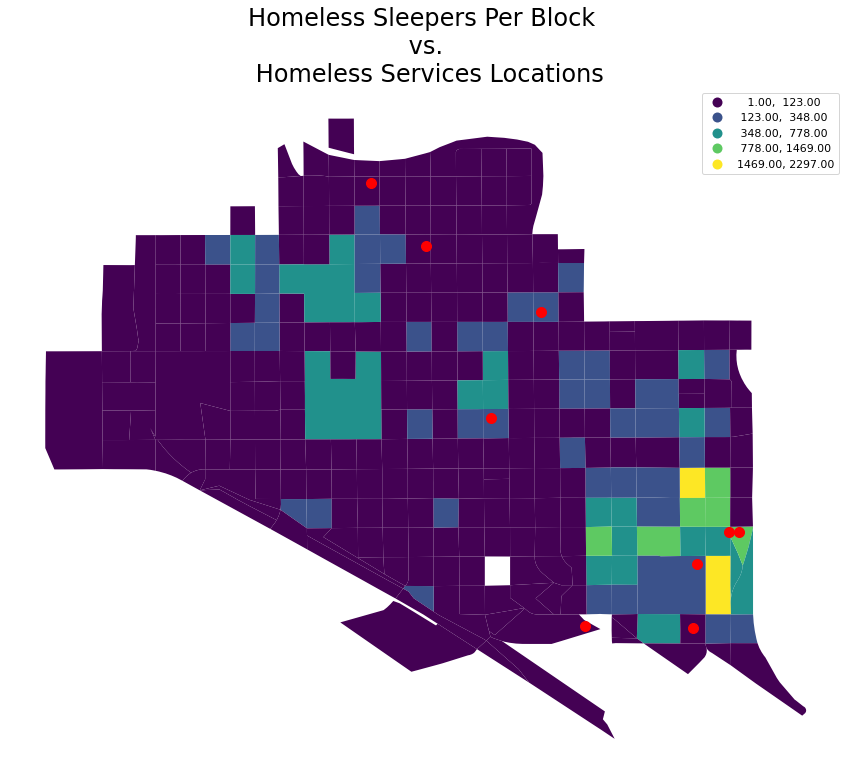

In [35]:
# Map showing locations of homeless services vs. coropleth with density of homeless sleepers

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry')


j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(15,15), scheme='fisher_jenks', legend=True);


# labels1=["Homeless Shelter & Service Locations", "Police & Sheriff Stations", "Trolley Stations"]
# red_patch = mpatches.Patch(facecolor='r') #this will create a red bar with black borders, you can leave out edgecolor if you do not want the borders
# blue_patch = mpatches.Patch(facecolor='b')
# yellow_patch = mpatches.Patch(facecolor='y')

# plt.legend(handles = [red_patch, blue_patch, yellow_patch],labels=labels1,
#        loc="upper left", 
#        borderaxespad=0.1)


ax.set_title("Homeless Sleepers Per Block \n vs. \n Homeless Services Locations", fontsize=24);

# # pt_1000.geometry.boundary.plot(ax=ax, color='red')
pt.plot(ax=ax, marker="o", markersize=100, color='red')
# policeHQ.plot(ax=ax, marker="o", markersize=100, color='blue')
# sheriffsDept.plot(ax=ax, marker="o", markersize=100, color='blue')

# # Trolley stations
# tAmericaPlaza.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tCourthouse.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tCivicCenter.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# t5thAve.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# tCityCollege.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tParkMarket.plot(ax=ax, marker="o", markersize=100, color='yellow')
# t12thImperial.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tGaslamp.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tConvention.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# tSeaportVillage.plot(ax=ax, marker="o", markersize=100, color='yellow') 

# Homeless shelters & services
# shNuevaVida.plot(ax=ax, color='red')
shCatholicCharities.plot(ax=ax, marker="o", markersize=100, color='red')
shYWCAcortez.plot(ax=ax, marker="o", markersize=100, color='red')
shRachelsNight.plot(ax=ax, marker="o", markersize=100, color='red')
shSalvationArmy.plot(ax=ax, marker="o", markersize=100, color='red')
shTravelersAid.plot(ax=ax, marker="o", markersize=100, color='red')
shPATHConnections.plot(ax=ax, marker="o", markersize=100, color='red')
serTransitionalStorage.plot(ax=ax, marker="o", markersize=100, color='red')
serNeilGoodDayCenter.plot(ax=ax, marker="o", markersize=100, color='red')

plt.axis('off')


(-117.17449529999999, -117.14445869999999, 32.70069015, 32.72517285)

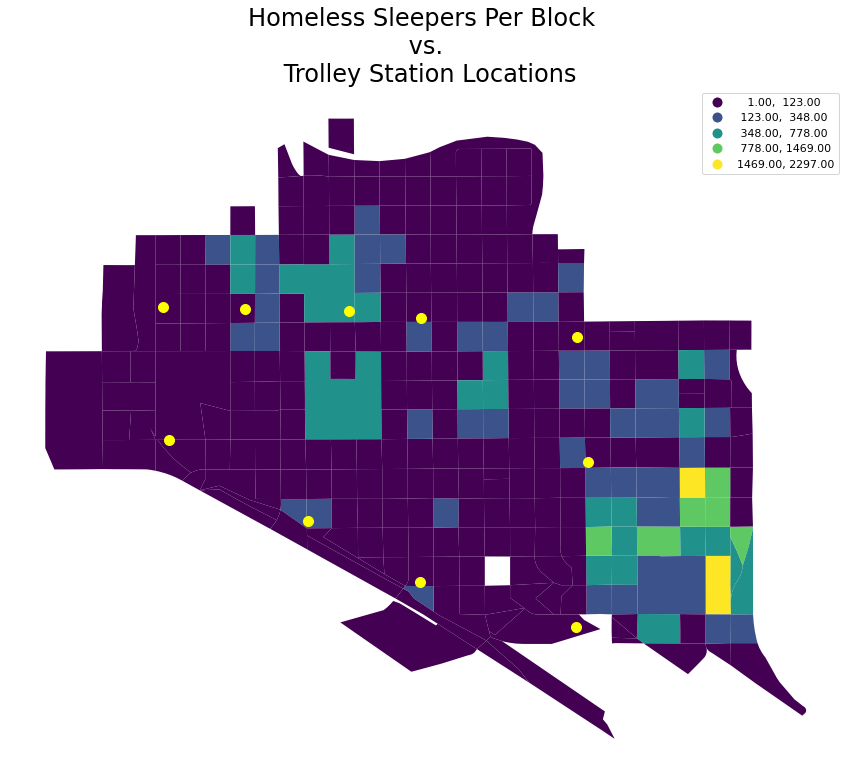

In [36]:
# Map showing trolley station locations vs. coropleth with density of homeless sleepers

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry')


j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(15,15), scheme='fisher_jenks', legend=True);


# labels1=["Homeless Shelter & Service Locations", "Police & Sheriff Stations", "Trolley Stations"]
# red_patch = mpatches.Patch(facecolor='r') #this will create a red bar with black borders, you can leave out edgecolor if you do not want the borders
# blue_patch = mpatches.Patch(facecolor='b')
# yellow_patch = mpatches.Patch(facecolor='y')

# plt.legend(handles = [red_patch, blue_patch, yellow_patch],labels=labels1,
#        loc="upper left", 
#        borderaxespad=0.1)


ax.set_title("Homeless Sleepers Per Block \n vs. \n Trolley Station Locations", fontsize=24);

# pt_1000.geometry.boundary.plot(ax=ax, color='red')
# pt.plot(ax=ax, marker="o", markersize=100, color='red')
# policeHQ.plot(ax=ax, marker="o", markersize=100, color='blue')
# sheriffsDept.plot(ax=ax, marker="o", markersize=100, color='blue')

# Trolley stations
tAmericaPlaza.plot(ax=ax, marker="o", markersize=100, color='yellow')
tCourthouse.plot(ax=ax, marker="o", markersize=100, color='yellow')
tCivicCenter.plot(ax=ax, marker="o", markersize=100, color='yellow') 
t5thAve.plot(ax=ax, marker="o", markersize=100, color='yellow') 
tCityCollege.plot(ax=ax, marker="o", markersize=100, color='yellow')
tParkMarket.plot(ax=ax, marker="o", markersize=100, color='yellow')
t12thImperial.plot(ax=ax, marker="o", markersize=100, color='yellow')
tGaslamp.plot(ax=ax, marker="o", markersize=100, color='yellow')
tConvention.plot(ax=ax, marker="o", markersize=100, color='yellow') 
tSeaportVillage.plot(ax=ax, marker="o", markersize=100, color='yellow') 

# # Homeless shelters & services
# # shNuevaVida.plot(ax=ax, color='red')
# shCatholicCharities.plot(ax=ax, marker="o", markersize=100, color='red')
# shYWCAcortez.plot(ax=ax, marker="o", markersize=100, color='red')
# shRachelsNight.plot(ax=ax, marker="o", markersize=100, color='red')
# shSalvationArmy.plot(ax=ax, marker="o", markersize=100, color='red')
# shTravelersAid.plot(ax=ax, marker="o", markersize=100, color='red')
# shPATHConnections.plot(ax=ax, marker="o", markersize=100, color='red')
# serTransitionalStorage.plot(ax=ax, marker="o", markersize=100, color='red')
# serNeilGoodDayCenter.plot(ax=ax, marker="o", markersize=100, color='red')

plt.axis('off')

(-117.17449529999999, -117.14445869999999, 32.70069015, 32.72517285)

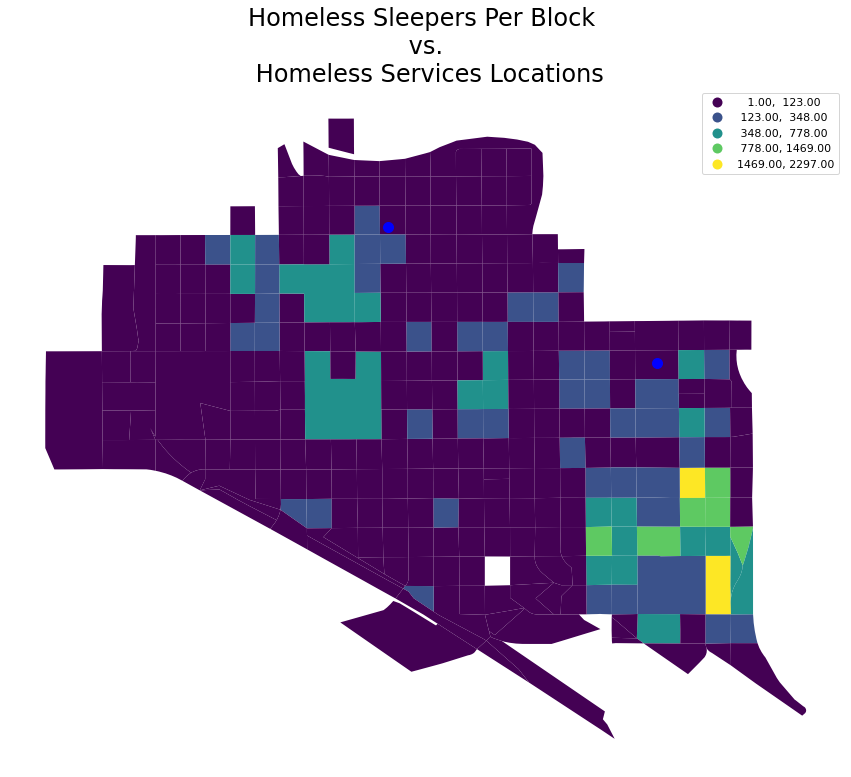

In [37]:
# Map showing police and sheriff station locations vs. coropleth with density of homeless sleepers

pt = gpd.GeoDataFrame([[Point(-117.1537487,32.705857)]], columns=['geometry'], geometry='geometry')


j = blocks.merge(hc[['geoid','records']].groupby('geoid').agg({'records':'count'}).reset_index(), on='geoid')

ax = j.plot(column='records', figsize=(15,15), scheme='fisher_jenks', legend=True);


# labels1=["Homeless Shelter & Service Locations", "Police & Sheriff Stations", "Trolley Stations"]
# red_patch = mpatches.Patch(facecolor='r') #this will create a red bar with black borders, you can leave out edgecolor if you do not want the borders
# blue_patch = mpatches.Patch(facecolor='b')
# yellow_patch = mpatches.Patch(facecolor='y')

# plt.legend(handles = [red_patch, blue_patch, yellow_patch],labels=labels1,
#        loc="upper left", 
#        borderaxespad=0.1)


ax.set_title("Homeless Sleepers Per Block \n vs. \n Homeless Services Locations", fontsize=24);

# pt_1000.geometry.boundary.plot(ax=ax, color='red')
# pt.plot(ax=ax, marker="o", markersize=100, color='red')
policeHQ.plot(ax=ax, marker="o", markersize=100, color='blue')
sheriffsDept.plot(ax=ax, marker="o", markersize=100, color='blue')

# # Trolley stations
# tAmericaPlaza.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tCourthouse.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tCivicCenter.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# t5thAve.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# tCityCollege.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tParkMarket.plot(ax=ax, marker="o", markersize=100, color='yellow')
# t12thImperial.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tGaslamp.plot(ax=ax, marker="o", markersize=100, color='yellow')
# tConvention.plot(ax=ax, marker="o", markersize=100, color='yellow') 
# tSeaportVillage.plot(ax=ax, marker="o", markersize=100, color='yellow') 

# # Homeless shelters & services
# # shNuevaVida.plot(ax=ax, color='red')
# shCatholicCharities.plot(ax=ax, marker="o", markersize=100, color='red')
# shYWCAcortez.plot(ax=ax, marker="o", markersize=100, color='red')
# shRachelsNight.plot(ax=ax, marker="o", markersize=100, color='red')
# shSalvationArmy.plot(ax=ax, marker="o", markersize=100, color='red')
# shTravelersAid.plot(ax=ax, marker="o", markersize=100, color='red')
# shPATHConnections.plot(ax=ax, marker="o", markersize=100, color='red')
# serTransitionalStorage.plot(ax=ax, marker="o", markersize=100, color='red')
# serNeilGoodDayCenter.plot(ax=ax, marker="o", markersize=100, color='red')

plt.axis('off')